***Imports***

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt


from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #Check if GPU is available before attempting any training. If not it will default at CPU.

Num GPUs Available:  0


***Read the data***

In [2]:
#df = pd.read_csv('2018-06-06-ss.cleaned.csv')
df = pd.read_csv('2018-06-06-pdb-intersect-pisces.csv')
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue
0,1FV1,F,NPVVHFFKNIVTPRTPPPSQ,CCCCCBCCCCCCCCCCCCCC,CCCCCECCCCCCCCCCCCCC,20,False,XRAY,1.90,0.23,0.27
1,1LM8,H,DLDLEMLAPYIPMDDDFQLR,CCCCCCCCCBCCSCCCEECC,CCCCCCCCCECCCCCCEECC,20,False,XRAY,1.85,0.20,0.24
2,1O06,A,EEDPDLKAAIQESLREAEEA,CCCHHHHHHHHHHHHHHHTC,CCCHHHHHHHHHHHHHHHCC,20,False,XRAY,1.45,0.19,0.22
3,1QOW,D,CTFTLPGGGGVCTLTSECI*,CCTTSCTTCSSTTSSTTCCC,CCCCCCCCCCCCCCCCCCCC,20,True,XRAY,1.06,0.14,1.00
4,1RDQ,I,TTYADFIASGRTGRRNAIHD,CHHHHHHTSSCSSCCCCEEC,CHHHHHHCCCCCCCCCCEEC,20,False,XRAY,1.26,0.13,0.16


***Clean dataset before training***

In [3]:
df.drop_duplicates() #remove duplicates if any in the dataset
df.dropna() #drop NaN values from the dataset if any
df.info() #analyse the columns and entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9078 entries, 0 to 9077
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         9078 non-null   object 
 1   chain_code     9078 non-null   object 
 2   seq            9078 non-null   object 
 3   sst8           9078 non-null   object 
 4   sst3           9078 non-null   object 
 5   len            9078 non-null   int64  
 6   has_nonstd_aa  9078 non-null   bool   
 7   Exptl.         9078 non-null   object 
 8   resolution     9078 non-null   float64
 9   R-factor       9078 non-null   float64
 10  FreeRvalue     9078 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 718.2+ KB


In [4]:
df = df.drop(columns=['sst8']) #Remove sst8 because we do not care about it, we only care about 'sst3' as explained in report.

df.head()

,pdb_id,chain_code,seq,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue
0,1FV1,F,NPVVHFFKNIVTPRTPPPSQ,CCCCCECCCCCCCCCCCCCC,20,False,XRAY,1.90,0.23,0.27
1,1LM8,H,DLDLEMLAPYIPMDDDFQLR,CCCCCCCCCECCCCCCEECC,20,False,XRAY,1.85,0.20,0.24
2,1O06,A,EEDPDLKAAIQESLREAEEA,CCCHHHHHHHHHHHHHHHCC,20,False,XRAY,1.45,0.19,0.22
3,1QOW,D,CTFTLPGGGGVCTLTSECI*,CCCCCCCCCCCCCCCCCCCC,20,True,XRAY,1.06,0.14,1.00
4,1RDQ,I,TTYADFIASGRTGRRNAIHD,CHHHHHHCCCCCCCCCCEEC,20,False,XRAY,1.26,0.13,0.16


In [5]:
#df = df.drop(df[df.has_nonstd_aa == True].index) #Test if has_nonstd_aa had any effect on the dataset. It had very little effect on the training so we kept it.
df.head()

,pdb_id,chain_code,seq,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue
0,1FV1,F,NPVVHFFKNIVTPRTPPPSQ,CCCCCECCCCCCCCCCCCCC,20,False,XRAY,1.90,0.23,0.27
1,1LM8,H,DLDLEMLAPYIPMDDDFQLR,CCCCCCCCCECCCCCCEECC,20,False,XRAY,1.85,0.20,0.24
2,1O06,A,EEDPDLKAAIQESLREAEEA,CCCHHHHHHHHHHHHHHHCC,20,False,XRAY,1.45,0.19,0.22
3,1QOW,D,CTFTLPGGGGVCTLTSECI*,CCCCCCCCCCCCCCCCCCCC,20,True,XRAY,1.06,0.14,1.00
4,1RDQ,I,TTYADFIASGRTGRRNAIHD,CHHHHHHCCCCCCCCCCEEC,20,False,XRAY,1.26,0.13,0.16


In [6]:
# NLP: Tokenization of the sequences
df['tokens'] = df['seq'].apply(lambda x: list(x)) #Split invidual characters into tokens
df['output'] = df['sst3'].apply(lambda x: list(x))
df.head()

,pdb_id,chain_code,seq,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue,tokens,output
0,1FV1,F,NPVVHFFKNIVTPRTPPPSQ,CCCCCECCCCCCCCCCCCCC,20,False,XRAY,1.90,0.23,0.27,"[N, P, V, V, H, F, F, K, N, I, V, T, P, R, T, ...","[C, C, C, C, C, E, C, C, C, C, C, C, C, C, C, ..."
1,1LM8,H,DLDLEMLAPYIPMDDDFQLR,CCCCCCCCCECCCCCCEECC,20,False,XRAY,1.85,0.20,0.24,"[D, L, D, L, E, M, L, A, P, Y, I, P, M, D, D, ...","[C, C, C, C, C, C, C, C, C, E, C, C, C, C, C, ..."
2,1O06,A,EEDPDLKAAIQESLREAEEA,CCCHHHHHHHHHHHHHHHCC,20,False,XRAY,1.45,0.19,0.22,"[E, E, D, P, D, L, K, A, A, I, Q, E, S, L, R, ...","[C, C, C, H, H, H, H, H, H, H, H, H, H, H, H, ..."
3,1QOW,D,CTFTLPGGGGVCTLTSECI*,CCCCCCCCCCCCCCCCCCCC,20,True,XRAY,1.06,0.14,1.00,"[C, T, F, T, L, P, G, G, G, G, V, C, T, L, T, ...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ..."
4,1RDQ,I,TTYADFIASGRTGRRNAIHD,CHHHHHHCCCCCCCCCCEEC,20,False,XRAY,1.26,0.13,0.16,"[T, T, Y, A, D, F, I, A, S, G, R, T, G, R, R, ...","[C, H, H, H, H, H, H, C, C, C, C, C, C, C, C, ..."


***Exploratory Data Analysis***

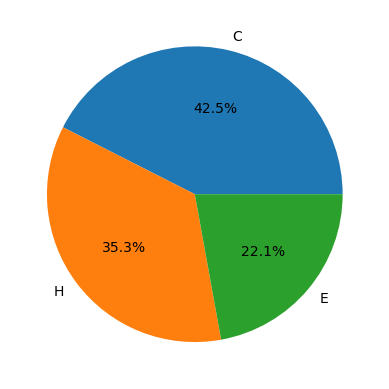

In [7]:
#Exploratory Data Analysis


fdist = FreqDist() #Frequency dictionary

for row in df['output']:
    for word in row:
        fdist[word] += 1 #update counts for each of the three letters

counts = fdist.most_common(3)

letters = []
numbers = []
for index, total in counts: #split into x,y to plot 
    letters.append(index)
    numbers.append(total)

#Source: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
plt.pie(numbers, labels = letters, autopct='%1.1f%%')
plt.show()


***The pie plot shows the percentage of the different secondary structures in the dataset. C: Random coil, H: Alpha Helix, E: Beta sheet***

In [8]:

dict = Dictionary(df['tokens']) #create a dictionary of all the tokens

freq_dist = {}

for index, label in dict.items(): #loop through label by label

    label_freq = FreqDist() #unique frequency distribution for each label

    for input, output in zip(df['tokens'], df['output']): #source: https://www.geeksforgeeks.org/python-iterate-multiple-lists-simultaneously/
        for i_w, o_w in zip(input, output): #input_word, output_word
            if i_w == label: #only add corresponding output for correct label
                label_freq[o_w] += 1

    freq_dist[label] = label_freq

print(freq_dist)




{'F': FreqDist({'H': 31875, 'E': 28754, 'C': 27852}), 'H': FreqDist({'C': 35699, 'H': 16347, 'E': 11578}), 'I': FreqDist({'E': 47058, 'H': 44731, 'C': 29981}), 'K': FreqDist({'C': 51860, 'H': 50315, 'E': 22256}), 'N': FreqDist({'C': 55936, 'H': 25751, 'E': 13436}), 'P': FreqDist({'C': 72309, 'H': 19511, 'E': 9995}), 'Q': FreqDist({'H': 37299, 'C': 31785, 'E': 14050}), 'R': FreqDist({'H': 47317, 'C': 41850, 'E': 22993}), 'S': FreqDist({'C': 73981, 'H': 38857, 'E': 25705}), 'T': FreqDist({'C': 54784, 'H': 32582, 'E': 32379}), 'V': FreqDist({'E': 63467, 'H': 46448, 'C': 40003}), 'A': FreqDist({'H': 89140, 'C': 62292, 'E': 30635}), 'D': FreqDist({'C': 73575, 'H': 40908, 'E': 16544}), 'E': FreqDist({'H': 70250, 'C': 53890, 'E': 22786}), 'L': FreqDist({'H': 92959, 'C': 57620, 'E': 50540}), 'M': FreqDist({'H': 20142, 'C': 19896, 'E': 10727}), 'Y': FreqDist({'H': 27621, 'E': 24970, 'C': 24883}), '*': FreqDist({'C': 115, 'H': 38, 'E': 3}), 'C': FreqDist({'C': 10278, 'H': 8034, 'E': 7901}), 'G':

In [9]:
#Function to retrieve pieplot for individual amino acids. Do not change.

def label_freq_dist(token):

    ## check if token is valid
    if token in freq_dist:
        token_freq = freq_dist[token] 
    else:
        return "Not valid token"

    indexes = []
    values = []
    for idx, value in token_freq.items():
        indexes.append(idx)
        values.append(value)
    plt.pie(values, labels=indexes, autopct='%1.1f%%') #show pie chart
    plt.show()
    return token_freq.items() #return numbers for user 



***Edit the amino acids in the parameter below to show the pie plot for a chosen amino acid.***

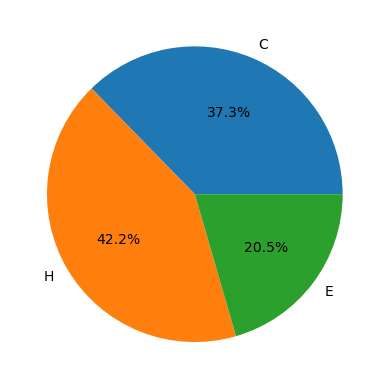

dict_items([('C', 41850), ('H', 47317), ('E', 22993)])

In [10]:
label_freq_dist('R')

***Padding to ensure all sequences is the similar length before sending it to the model***

In [11]:
#Padding to get uniform length and encoding characters

#Source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer


tokenizer = Tokenizer(char_level=True) #Tokenizer from character to integer
tokenizer.fit_on_texts(df['tokens']) #Train tokenizer on text/list to only tokenize amino acids in dictionary.

df['tokens_int'] = tokenizer.texts_to_sequences(df['tokens']) #Convert list to encoded integers

output_mapping = {'C': 1, 'H': 2, 'E': 3} #Output mapped to integers
df['outputs_int'] = df['output'].apply(lambda x: [output_mapping[label] for label in x]) #apply the mapping to the outputs



max_length = df['len'].max() #max length according to dataset



#Pad input tokens by adding 0 to match the maximum length in the dataset. (5037) 
padded_tokens = pad_sequences(df['tokens_int'].to_list(), maxlen=max_length, padding='post', value=0)
padded_outputs = pad_sequences(df['outputs_int'].to_list(), maxlen=max_length, padding='post', value=0)


print(max_length)
assert len(padded_tokens[0]) == max_length
assert len(padded_outputs[0]) == max_length #ensure padding is done correctly




1632


***Segment for exporting the tokenizer, to use it in the executable file***

In [12]:
import pickle

df.head()

# saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

,pdb_id,chain_code,seq,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue,tokens,output,tokens_int,outputs_int
0,1FV1,F,NPVVHFFKNIVTPRTPPPSQ,CCCCCECCCCCCCCCCCCCC,20,False,XRAY,1.90,0.23,0.27,"[N, P, V, V, H, F, F, K, N, I, V, T, P, R, T, ...","[C, C, C, C, C, E, C, C, C, C, C, C, C, C, C, ...","[13, 12, 4, 4, 17, 14, 14, 8, 13, 9, 4, 10, 12...","[1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1LM8,H,DLDLEMLAPYIPMDDDFQLR,CCCCCCCCCECCCCCCEECC,20,False,XRAY,1.85,0.20,0.24,"[D, L, D, L, E, M, L, A, P, Y, I, P, M, D, D, ...","[C, C, C, C, C, C, C, C, C, E, C, C, C, C, C, ...","[7, 1, 7, 1, 5, 18, 1, 2, 12, 16, 9, 12, 18, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, ..."
2,1O06,A,EEDPDLKAAIQESLREAEEA,CCCHHHHHHHHHHHHHHHCC,20,False,XRAY,1.45,0.19,0.22,"[E, E, D, P, D, L, K, A, A, I, Q, E, S, L, R, ...","[C, C, C, H, H, H, H, H, H, H, H, H, H, H, H, ...","[5, 5, 7, 12, 7, 1, 8, 2, 2, 9, 15, 5, 6, 1, 1...","[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,1QOW,D,CTFTLPGGGGVCTLTSECI*,CCCCCCCCCCCCCCCCCCCC,20,True,XRAY,1.06,0.14,1.00,"[C, T, F, T, L, P, G, G, G, G, V, C, T, L, T, ...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[20, 10, 14, 10, 1, 12, 3, 3, 3, 3, 4, 20, 10,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,1RDQ,I,TTYADFIASGRTGRRNAIHD,CHHHHHHCCCCCCCCCCEEC,20,False,XRAY,1.26,0.13,0.16,"[T, T, Y, A, D, F, I, A, S, G, R, T, G, R, R, ...","[C, H, H, H, H, H, H, C, C, C, C, C, C, C, C, ...","[10, 10, 16, 2, 7, 14, 9, 2, 6, 3, 11, 10, 3, ...","[1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, ..."


***Segment for creating the model, before training. It is commented out as it is not advisable to do the training unless you PC has a graphics card like NVIDIA RTX 3080. The training takes approx. 6 hours.***
***The model we trained is imported further down, and can be used***

In [15]:

# print(tf.version.VERSION)

# #Very simple LSTM model


# model = Sequential()
# model.add(Embedding(input_dim=len(freq_dist)+1, output_dim=64, mask_zero = True))
# model.add(Bidirectional(GRU(units=200, return_sequences=True)))
# model.add(Dropout(0.75, noise_shape=None, seed=None))
# model.add(Bidirectional(GRU(units=200, return_sequences=True)))
# # model.add(Dropout(0.2, noise_shape=None, seed=None))
# # model.add(Bidirectional(GRU(units=50, return_sequences=True)))
# # model.add(Dropout(0.2, noise_shape=None, seed=None))
# #model.add(Bidirectional(GRU(units=20, return_sequences=True)))
# model.add(TimeDistributed(Dense(4, activation='softmax')))

# stop_callback = EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.001,
#     patience=2,
# )


# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])


***Split data into training and test data set, the function is imported from scikit-learn and randomly shuffles data data into a data set and a test set, to both train and do validation on.***

In [13]:
#Split data into Train and Test split:

X_train, X_test, y_train, y_test = train_test_split(padded_tokens, padded_outputs, test_size=0.25, random_state=42)



In [19]:

#print(len(X_train))
#print(len(X_test))

***Segment for training the dataset, It is commented out as it is not advisable to do the training unless you PC has a graphics card like NVIDIA RTX 3080. The training takes approx. 6 hours.***

In [ ]:
# train_model = model.fit(X_train, y_train, batch_size=None, epochs=40, callbacks=stop_callback, validation_data=(X_test, y_test))

Epoch 1/40


***The tests performance, can only be ran if the data is trained. Our model gave us an accuracy of 0.84 on the test data set of unseen data.***

In [ ]:
# results = model.evaluate(X_test, y_test, batch_size=None)
# print("test loss, test acc:", results)

3077/3077 [==============================] - 276s 90ms/step - loss: 0.0201 - accuracy: 0.8401
test loss, test acc: [0.020141690969467163, 0.8400591015815735]


***Import the model we trained:***

In [14]:
loaded_model = tf.keras.models.load_model('trained_model.keras')

***Evaluation of the loaded model:***

In [15]:
results = loaded_model.evaluate(X_test, y_test, batch_size=None)
print("test loss, test acc:", results)

***Functions to display the prediction. Includes removal of padding, decoding and visual coloring of the correct/missed predictions made.***

In [16]:
def remove_padding(prediction, answer):

    answer_indexes =  np.where(answer != 0)

    pred = prediction[answer_indexes]
    ans = answer[answer_indexes]

    assert len(pred) == len(ans)

    return pred, ans 

In [17]:
def decode_prediction(pred, ans):
    
    reversed_mapping = {1: 'C', 2: 'H', 3: 'E'}
    
    decode_pred = [reversed_mapping[label] for label in pred]
    decode_ans = [reversed_mapping[label] for label in ans]
    
    return decode_pred, decode_ans

In [19]:
#DISCLAIMER: The color_compare and color_true_answer functions is partly generated from ChatGPT: https://chat.openai.com/
#The code is only used for easier visibility when comparing predictions with the answer and has no effect on the prediction or performance of the model.
#The code uses ANSI escape code to change the visible text color.
def color_compare(pred, ans):
    correct = 0
    print("Prediction: ")
    for a, b in zip(pred, ans):
        if a == b:
            print(f"\033[92m{a}\033[0m", end=' ')  # Green for match
            correct += 1
        else:
            print(f"\033[91m{a}\033[0m", end=' ')  # Red for mismatch
    print()
    return correct/len(ans)  # Return 

def color_true_answer(pred, ans):
    count = 0
    print("True answer: ")
    for a, b in zip(pred, ans):
        if a != b:
            print(f"\033[91m{b}\033[0m", end=' ')  # Red for mismatch
            count += 1
        else:
            print(f"{b}", end=' ')  # Default color for match
    print()  # Newline at the end
    return count

***Predictions made on the dataset: y_test and X_test needs to have similar indexes.***

***Including classification report with precision, f1-score and recall for all the different classes***

In [20]:
from sklearn.metrics import classification_report

#Because classification report and confusion matrix does not support multi-class multi-output we need to use an alternate way
#Creates two empty lists to collect data about every single prediction made
all_predictions = []
all_answer = []

prediction_input = X_test
prediction_answers = y_test

prediction = loaded_model.predict(prediction_input)  
prediction = np.argmax(prediction, axis=-1)

for x, y in zip(prediction, prediction_answers):
    pred, ans = remove_padding(x, y)
    pred, ans = decode_prediction(pred, ans)

    all_predictions.extend(pred)
    all_answer.extend(ans)

    accuracy = color_compare(pred, ans)
    mismatches = color_true_answer(pred, ans)

    print("The accuracy is:", accuracy)
    print("The total number of mismatches is:", mismatches, "out of", len(ans))
    print() #Newline



Prediction: 
C C H H H H H H H H H H H H C C C C C C C E E E E C C C C C C C C H H H H H H H H H H H H C H C C C C C C C C E E E E E E E E E C C C C E E E E E E E E E C C C C C E E E E E E E E E H C C C C C C C C C C C C 
True answer: 
C C H H H H H H H H H H H H H C C C E E E E E E E E E E E E E E C H H H H H H H C C C C E E E E E E E C C C C E E E E E E E E E E C C E E E E E E E E E E E E C C E E E E E E E E E E E E E C C C C C C C C C C 
The accuracy is: 0.7115384615384616
The total number of mismatches is: 30 out of 104



***Classification report and confusion matrix***

In [21]:
print("Classification report: ")
print(classification_report(all_answer, all_predictions))

Classification report: 
              precision    recall  f1-score   support

           C       0.51      0.86      0.64        28
           E       1.00      0.55      0.71        56
           H       0.73      0.95      0.83        20

    accuracy                           0.71       104
   macro avg       0.75      0.79      0.73       104
weighted avg       0.82      0.71      0.71       104



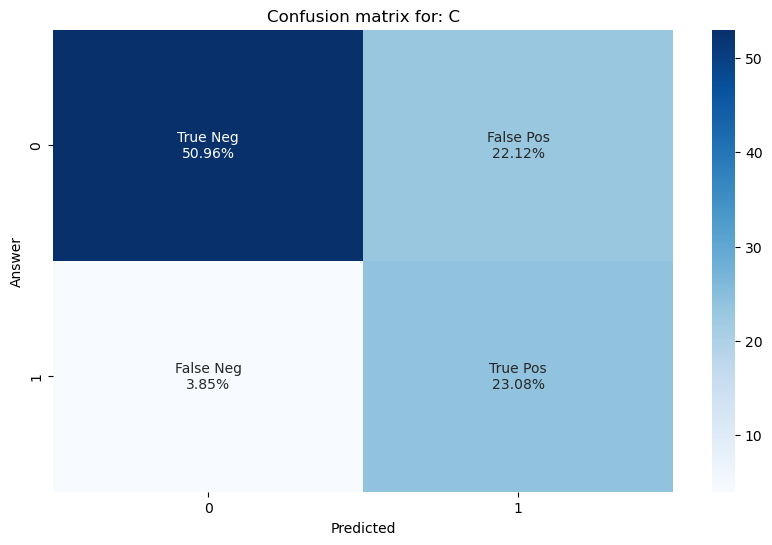

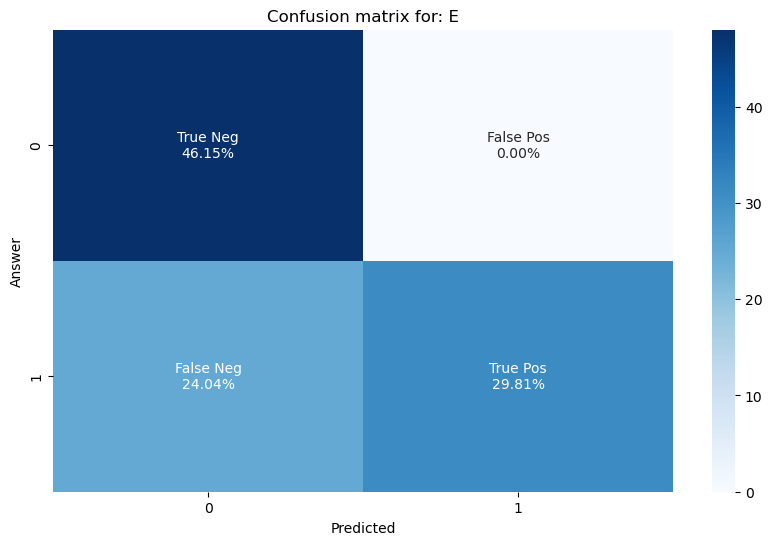

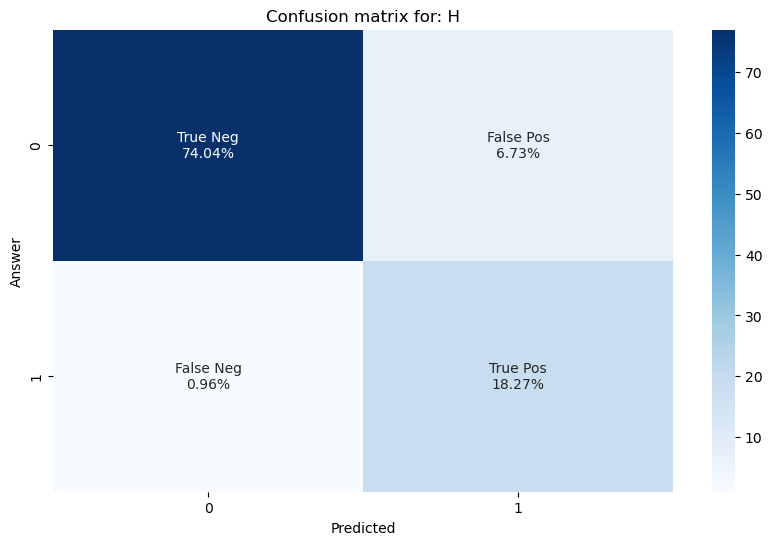

In [51]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

matrixes = multilabel_confusion_matrix(all_answer, all_predictions) #one confusion matrix for each of C, E, H

class_labels = ['C', 'E', 'H']
for i, matrix in enumerate(matrixes):
    percentage_dist = (matrix / matrix.sum())*100 #Creates a distribution of the percentages of counts in the different labels.
    labels = [[f"True Neg\n{percentage_dist[0,0]:.2f}%", f'False Pos\n{percentage_dist[0,1]:.2f}%'], [f'False Neg\n{percentage_dist[1,0]:.2f}%', f'True Pos\n{percentage_dist[1,1]:.2f}%']]
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    plt.title(f"Confusion matrix for: {class_labels[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("Answer")
    plt.show()


***Everything below is how to preprocess the data in order to use this model to make predictions on other datasets.***

In [ ]:
# df_test = pd.read_csv('protein-secondary-structure.test.csv')
# df_test.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue
0,NaN,NaN,ENLKLGFLVKQPEEPWFQTEWKFADKAGKDLGFEVIKIAVPDGEKT...,NaN,CCCCCCEEECCCCCCCHHHHHHHHHHHHHHCCCCCCEEECCCHHHH...,306,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,APAFSVSPASGASDGQSVSVSVAAAGETYYIAQCAPVGGQDACNPA...,NaN,CCEEEEECCCCCCCCCEEEEEEECCCCEEEEEEECEECCEECCCCC...,108,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,GFPIPDPYCWDISFRTFYTIVDDEHKTLFNGILLLSQADNADHLNE...,NaN,CCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHCCCHHHHHH...,113,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,RDFTPPTVKILQSSCDGGGHFPPTIQLLCLVSGYTPGTINITWLED...,NaN,CCCCCCEEEEECCCCCCCCCCCCEEEEEEEEEEECCCCCEEEEECC...,322,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,RICFNQHSSQPQTTKTCSPGESSCYHKQWSDFRGTIIERGCGCPTV...,NaN,CEEECCCCCCCCCEEECCCCCCCEEEEEEEECCEEEEEEEECCCCC...,62,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df_test.drop_duplicates() #remove duplicates if any in the dataset
# df_test.dropna() #drop NaN values from the dataset if any
# df_test.info() #analyse the columns and entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         0 non-null      float64
 1   chain_code     0 non-null      float64
 2   seq            15 non-null     object 
 3   sst8           0 non-null      float64
 4   sst3           15 non-null     object 
 5   len            15 non-null     int64  
 6   has_nonstd_aa  0 non-null      float64
 7   Exptl.         0 non-null      float64
 8   resolution     0 non-null      float64
 9   R-factor       0 non-null      float64
 10  FreeRvalue     0 non-null      float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.4+ KB


In [ ]:
# df_test = df_test.drop(columns=['sst8', 'has_nonstd_aa', 'Exptl.', 'resolution', 'R-factor', 'FreeRvalue']) #Remove sst8 because we do not care about it, we look at sst3.
# df_test['tokens'] = df_test['seq'].apply(lambda x: list(x)) #Split invidual characters into tokens
# df_test['output'] = df_test['sst3'].apply(lambda x: list(x))

# df_test['tokens_int'] = tokenizer.texts_to_sequences(df_test['tokens']) #Convert list to encoded integers

# output_mapping = {'C': 1, 'H': 2, 'E': 3} #Mapped to high numbers to efficiently differentiate with the amino acids
# df_test['outputs_int'] = df_test['output'].apply(lambda x: [output_mapping[label] for label in x])

# df_test.head()


,pdb_id,chain_code,seq,sst3,len,tokens,output,tokens_int,outputs_int
0,NaN,NaN,ENLKLGFLVKQPEEPWFQTEWKFADKAGKDLGFEVIKIAVPDGEKT...,CCCCCCEEECCCCCCCHHHHHHHHHHHHHHCCCCCCEEECCCHHHH...,306,"[E, N, L, K, L, G, F, L, V, K, Q, P, E, E, P, ...","[C, C, C, C, C, C, E, E, E, C, C, C, C, C, C, ...","[5, 13, 1, 7, 1, 3, 14, 1, 4, 7, 15, 12, 5, 5,...","[1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, ..."
1,NaN,NaN,APAFSVSPASGASDGQSVSVSVAAAGETYYIAQCAPVGGQDACNPA...,CCEEEEECCCCCCCCCEEEEEEECCCCEEEEEEECEECCEECCCCC...,108,"[A, P, A, F, S, V, S, P, A, S, G, A, S, D, G, ...","[C, C, E, E, E, E, E, C, C, C, C, C, C, C, C, ...","[2, 12, 2, 14, 6, 4, 6, 12, 2, 6, 3, 2, 6, 8, ...","[1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,NaN,NaN,GFPIPDPYCWDISFRTFYTIVDDEHKTLFNGILLLSQADNADHLNE...,CCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHCCCHHHHHH...,113,"[G, F, P, I, P, D, P, Y, C, W, D, I, S, F, R, ...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[3, 14, 12, 9, 12, 8, 12, 16, 19, 20, 8, 9, 6,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,NaN,NaN,RDFTPPTVKILQSSCDGGGHFPPTIQLLCLVSGYTPGTINITWLED...,CCCCCCEEEEECCCCCCCCCCCCEEEEEEEEEEECCCCCEEEEECC...,322,"[R, D, F, T, P, P, T, V, K, I, L, Q, S, S, C, ...","[C, C, C, C, C, C, E, E, E, E, E, C, C, C, C, ...","[11, 8, 14, 10, 12, 12, 10, 4, 7, 9, 1, 15, 6,...","[1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, ..."
4,NaN,NaN,RICFNQHSSQPQTTKTCSPGESSCYHKQWSDFRGTIIERGCGCPTV...,CEEECCCCCCCCCEEECCCCCCCEEEEEEEECCEEEEEEEECCCCC...,62,"[R, I, C, F, N, Q, H, S, S, Q, P, Q, T, T, K, ...","[C, E, E, E, C, C, C, C, C, C, C, C, C, E, E, ...","[11, 9, 19, 14, 13, 15, 17, 6, 6, 15, 12, 15, ...","[1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, ..."


In [ ]:
# padded_tokens_test = pad_sequences(df_test['tokens_int'].to_list(), maxlen=max_length, padding='post', value=0)
# padded_outputs_test = pad_sequences(df_test['outputs_int'].to_list(), maxlen=max_length, padding='post', value=0)

# results = model.evaluate(padded_tokens_test, padded_outputs_test, batch_size=None)
# print("test loss, test acc:", results)

1/1 [==============================] - 0s 351ms/step - loss: 0.0250 - accuracy: 0.7793
test loss, test acc: [0.025048118084669113, 0.7792613506317139]


In [ ]:
# model.save("trained_model.keras")

# dict = Dictionary(df['tokens'])
# corpus = [dict.doc2bow(row) for row in df['tokens']]

# model = TfidfModel(corpus)
# vector = model[corpus[0]]
# for id, score in vector:
#     token = dict[id]
#     print(token, score)




In [ ]:

# le = LabelEncoder()
# y = le.fit_transform(df['sst3'])

# X_train, X_test, y_train, y_test = train_test_split(model[corpus], y, test_size=0.3, random_state=42)